In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier


In [7]:
lifetime = pd.read_csv('Courier_lifetime_data.csv')
weekly = pd.read_csv('Courier_weekly_data.csv')


In [8]:
len(set(list(lifetime.courier)))

7524

In [9]:
len(set(list(weekly.courier)))

759

only 1/10 aprox. of the couriers have weekly data

(array([ 501., 1110., 1103.,  782.,  387.,  135.,   66.,   20.,   11.,
           2.]),
 array([  1. ,  17.8,  34.6,  51.4,  68.2,  85. , 101.8, 118.6, 135.4,
        152.2, 169. ]),
 <a list of 10 Patch objects>)

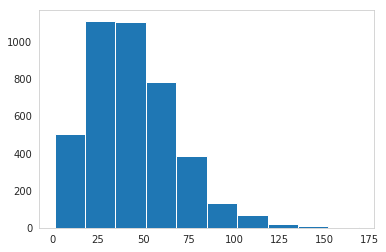

In [10]:
plt.hist(weekly.feature_2)

In [13]:
# keep only feature_2 values within +3 to -3 standard deviations 
outliers_ix = lifetime.index[np.abs(lifetime.feature_2-lifetime.feature_2.mean()) >= (3*lifetime.feature_2.std())]
lifetime.loc[outliers_ix, 'feature_2'] = np.NaN

In [15]:
#1st find couriers that do have weekly data to inspect the distributions
merge = pd.merge(lifetime, weekly, on='courier', how='right') #.to_csv('merge.csv')

#Then get the complete dataset. Lots of couriers will have lifetime data but no weekly data:
merge_all = pd.merge(lifetime, weekly, on='courier', how='left') #.to_csv('merge.csv')

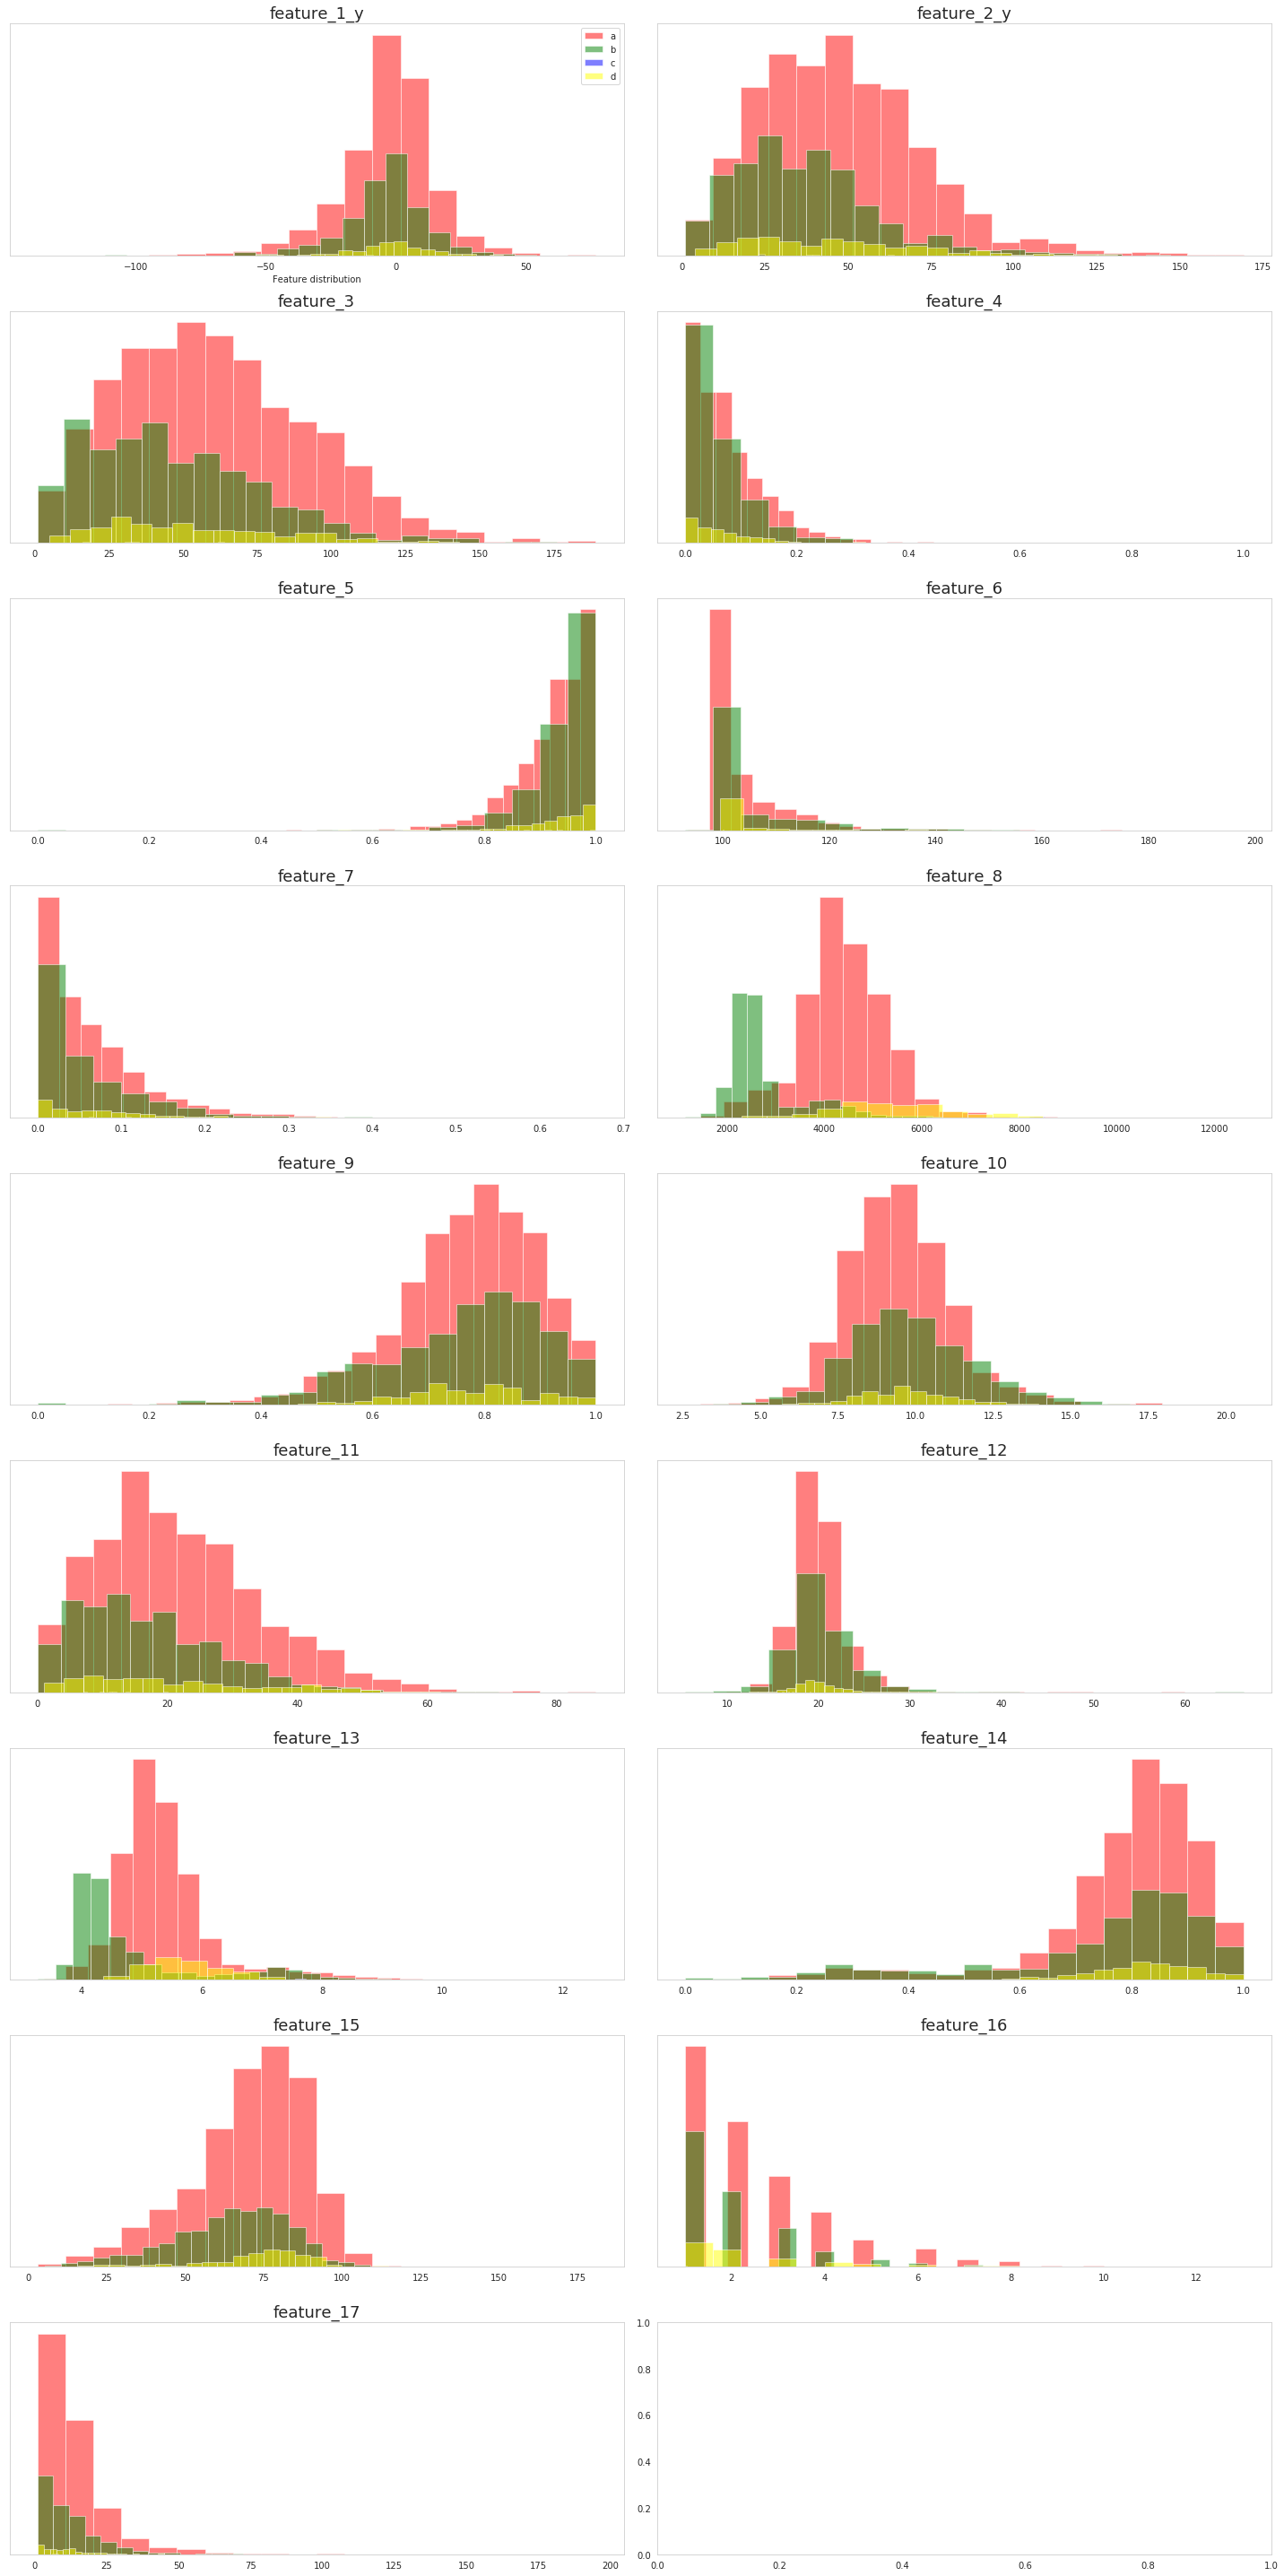

In [16]:

a = merge.loc[merge.feature_1_x=='a']
b = merge.loc[merge.feature_1_x=='b']
c = merge.loc[merge.feature_1_x=='c']
d = merge.loc[merge.feature_1_x=='d']

weekly_features = ['feature_1_y',
       'feature_2_y', 'feature_3', 'feature_4', 'feature_5', 'feature_6',
       'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
       'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16',
       'feature_17']

fig, axes = plt.subplots(9, 2, figsize=(20,40))

ax = axes.flatten() #ravel()

for i in range(len(weekly_features)):
    ax[i].hist(a.loc[:,weekly_features[i]], bins=20, color='red', alpha=.5)
    ax[i].hist(b.loc[:,weekly_features[i]], bins=20, color='green', alpha=.5)
    ax[i].hist(c.loc[:,weekly_features[i]], bins=20, color='blue', alpha=.5)
    ax[i].hist(d.loc[:,weekly_features[i]], bins=20, color='yellow', alpha=.5)
    ax[i].set_title(weekly_features[i], fontsize=18)
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature distribution")
ax[0].legend(["a", "b", "c", "d"], loc="best")
fig.tight_layout()


plt.show()

* Some of the features are clearly dependent on the category: a, b, c, d. Like feature 8 and feature 15
* Category a has the most weekly data. In other words, most of the couriers that have weekly data belong to a
* Category c has almost no weekly data

In [17]:
#Impute missing values with combinations of feature_1_x and feature_2_x
#For example, of 103 couriers with feature1: a, feature2: 31.0 
#43 of them have weekly data. Impute the remaining 60 ones with the median of the 43

list_f1 = list(set(merge_all.feature_1_x))
list_f2 = list(set(merge_all[merge_all.feature_2_x.notnull()].feature_2_x))

frames = []
for f1 in list_f1:
  for f2 in list_f2:
    df = merge_all.loc[merge_all.feature_1_x==f1][merge_all.feature_2_x==f2]
    if len(df.dropna())>0: #some feature 1, feature 2 combinations don't have any weekly data at all
      df = df.fillna(df[weekly_features].dropna().median())
      frames.append(df)
    else:
      df = df.fillna(merge_all.loc[merge_all.feature_1_x==f1].dropna().median())
      frames.append(df)
#And then for the 1227 couriers that have feature_1 but no feature_2 just impute the median of the whole group a, b, c, d
for f1 in list_f1:
  df = merge_all[merge_all.feature_2_x.isnull()][merge_all.feature_1_x==f1]
  df = df.fillna(df[weekly_features].dropna().median())
  frames.append(df)
data = pd.concat(frames)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
#But in the imputed data, feature_2_x is still missing
missing_f2 = len(data[data['feature_2_x'].isnull()])
print("rows missing feature_2_x: %s"%missing_f2)

rows missing feature_2_x: 1227


In [24]:
#With the imputed data I can now knn-predict those feature_2_x:
X = np.matrix(data[data['feature_2_x'].notnull()][weekly_features])
y = np.matrix(data['feature_2_x'].dropna()).T

#k = 5 by default
regr = KNeighborsRegressor().fit(X, y)
feature_2_x_ = regr.predict(np.matrix(data[weekly_features]))#[:, 'feature_2_x']
data['feature_2_x_'] = feature_2_x_ #[int(i) for i in feature_2_x_]
#Replace the missing values in feature_2_x with the knn-predicted feature_2_x_ values
missing_f2_ix = data.index[data.feature_2_x.isnull()]
predicted_f2  = data[data.feature_2_x.isnull()].feature_2_x_
data.loc[missing_f2_ix, 'feature_2_x'] = predicted_f2
data.sample(10)

,courier,feature_1_x,feature_2_x,week,feature_1_y,feature_2_y,feature_3,feature_4,feature_5,feature_6,...,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_2_x_
1613,167887,b,50.0,11.0,-2.0,47.0,83.0,0.02410,0.97590,100.0000,...,0.87950,9.670282,30.0,21.160602,4.116145,0.84340,84.009456,3.0,11.0,41.88
4404,397856,b,34.0,NaN,-14.0,36.0,55.5,0.03850,0.96150,101.7639,...,0.79860,11.264423,24.5,22.402764,4.157216,0.84335,73.889043,2.0,17.5,34.00
4884,437091,a,26.0,8.0,-4.0,42.0,74.0,0.06760,0.93240,100.0000,...,0.75680,8.148870,21.0,21.988243,5.050000,0.78380,78.661376,1.0,8.0,31.60
4113,379136,c,35.4,6.0,-10.0,40.0,35.0,0.20000,0.80000,102.8571,...,0.45710,8.120483,12.0,16.027714,6.312286,0.60000,52.024306,1.0,26.0,34.60
10690,950302,b,25.0,NaN,-7.5,24.5,27.5,0.05505,0.94495,100.0000,...,0.72485,9.801583,10.0,18.647148,4.211720,0.80285,68.433709,1.5,7.5,25.00
7950,640125,b,18.0,NaN,-14.0,27.0,33.0,0.02940,0.97060,100.0000,...,0.84850,10.196289,11.0,21.888889,4.400000,0.87880,65.511905,1.0,7.0,18.00
2018,206760,a,27.0,NaN,-2.0,45.0,53.0,0.06380,0.93620,100.0000,...,0.78380,9.322289,17.0,19.719672,5.033929,0.82170,73.706667,2.0,11.0,27.00
2111,219361,b,27.0,NaN,-4.0,38.0,55.0,0.03130,0.96880,106.6000,...,0.82540,9.793695,19.0,20.378750,4.391429,0.83910,71.599594,2.0,9.0,27.00
9651,853293,b,20.0,NaN,-6.0,28.5,28.5,0.03300,0.96700,100.0000,...,0.76255,9.495808,8.0,19.215476,4.186875,0.83320,59.202222,1.0,7.0,20.00
1437,157239,a,36.0,8.0,10.0,75.0,123.0,0.12200,0.87800,107.3415,...,0.70730,7.577776,25.0,18.658699,5.562683,0.78860,80.331481,2.0,16.0,35.96


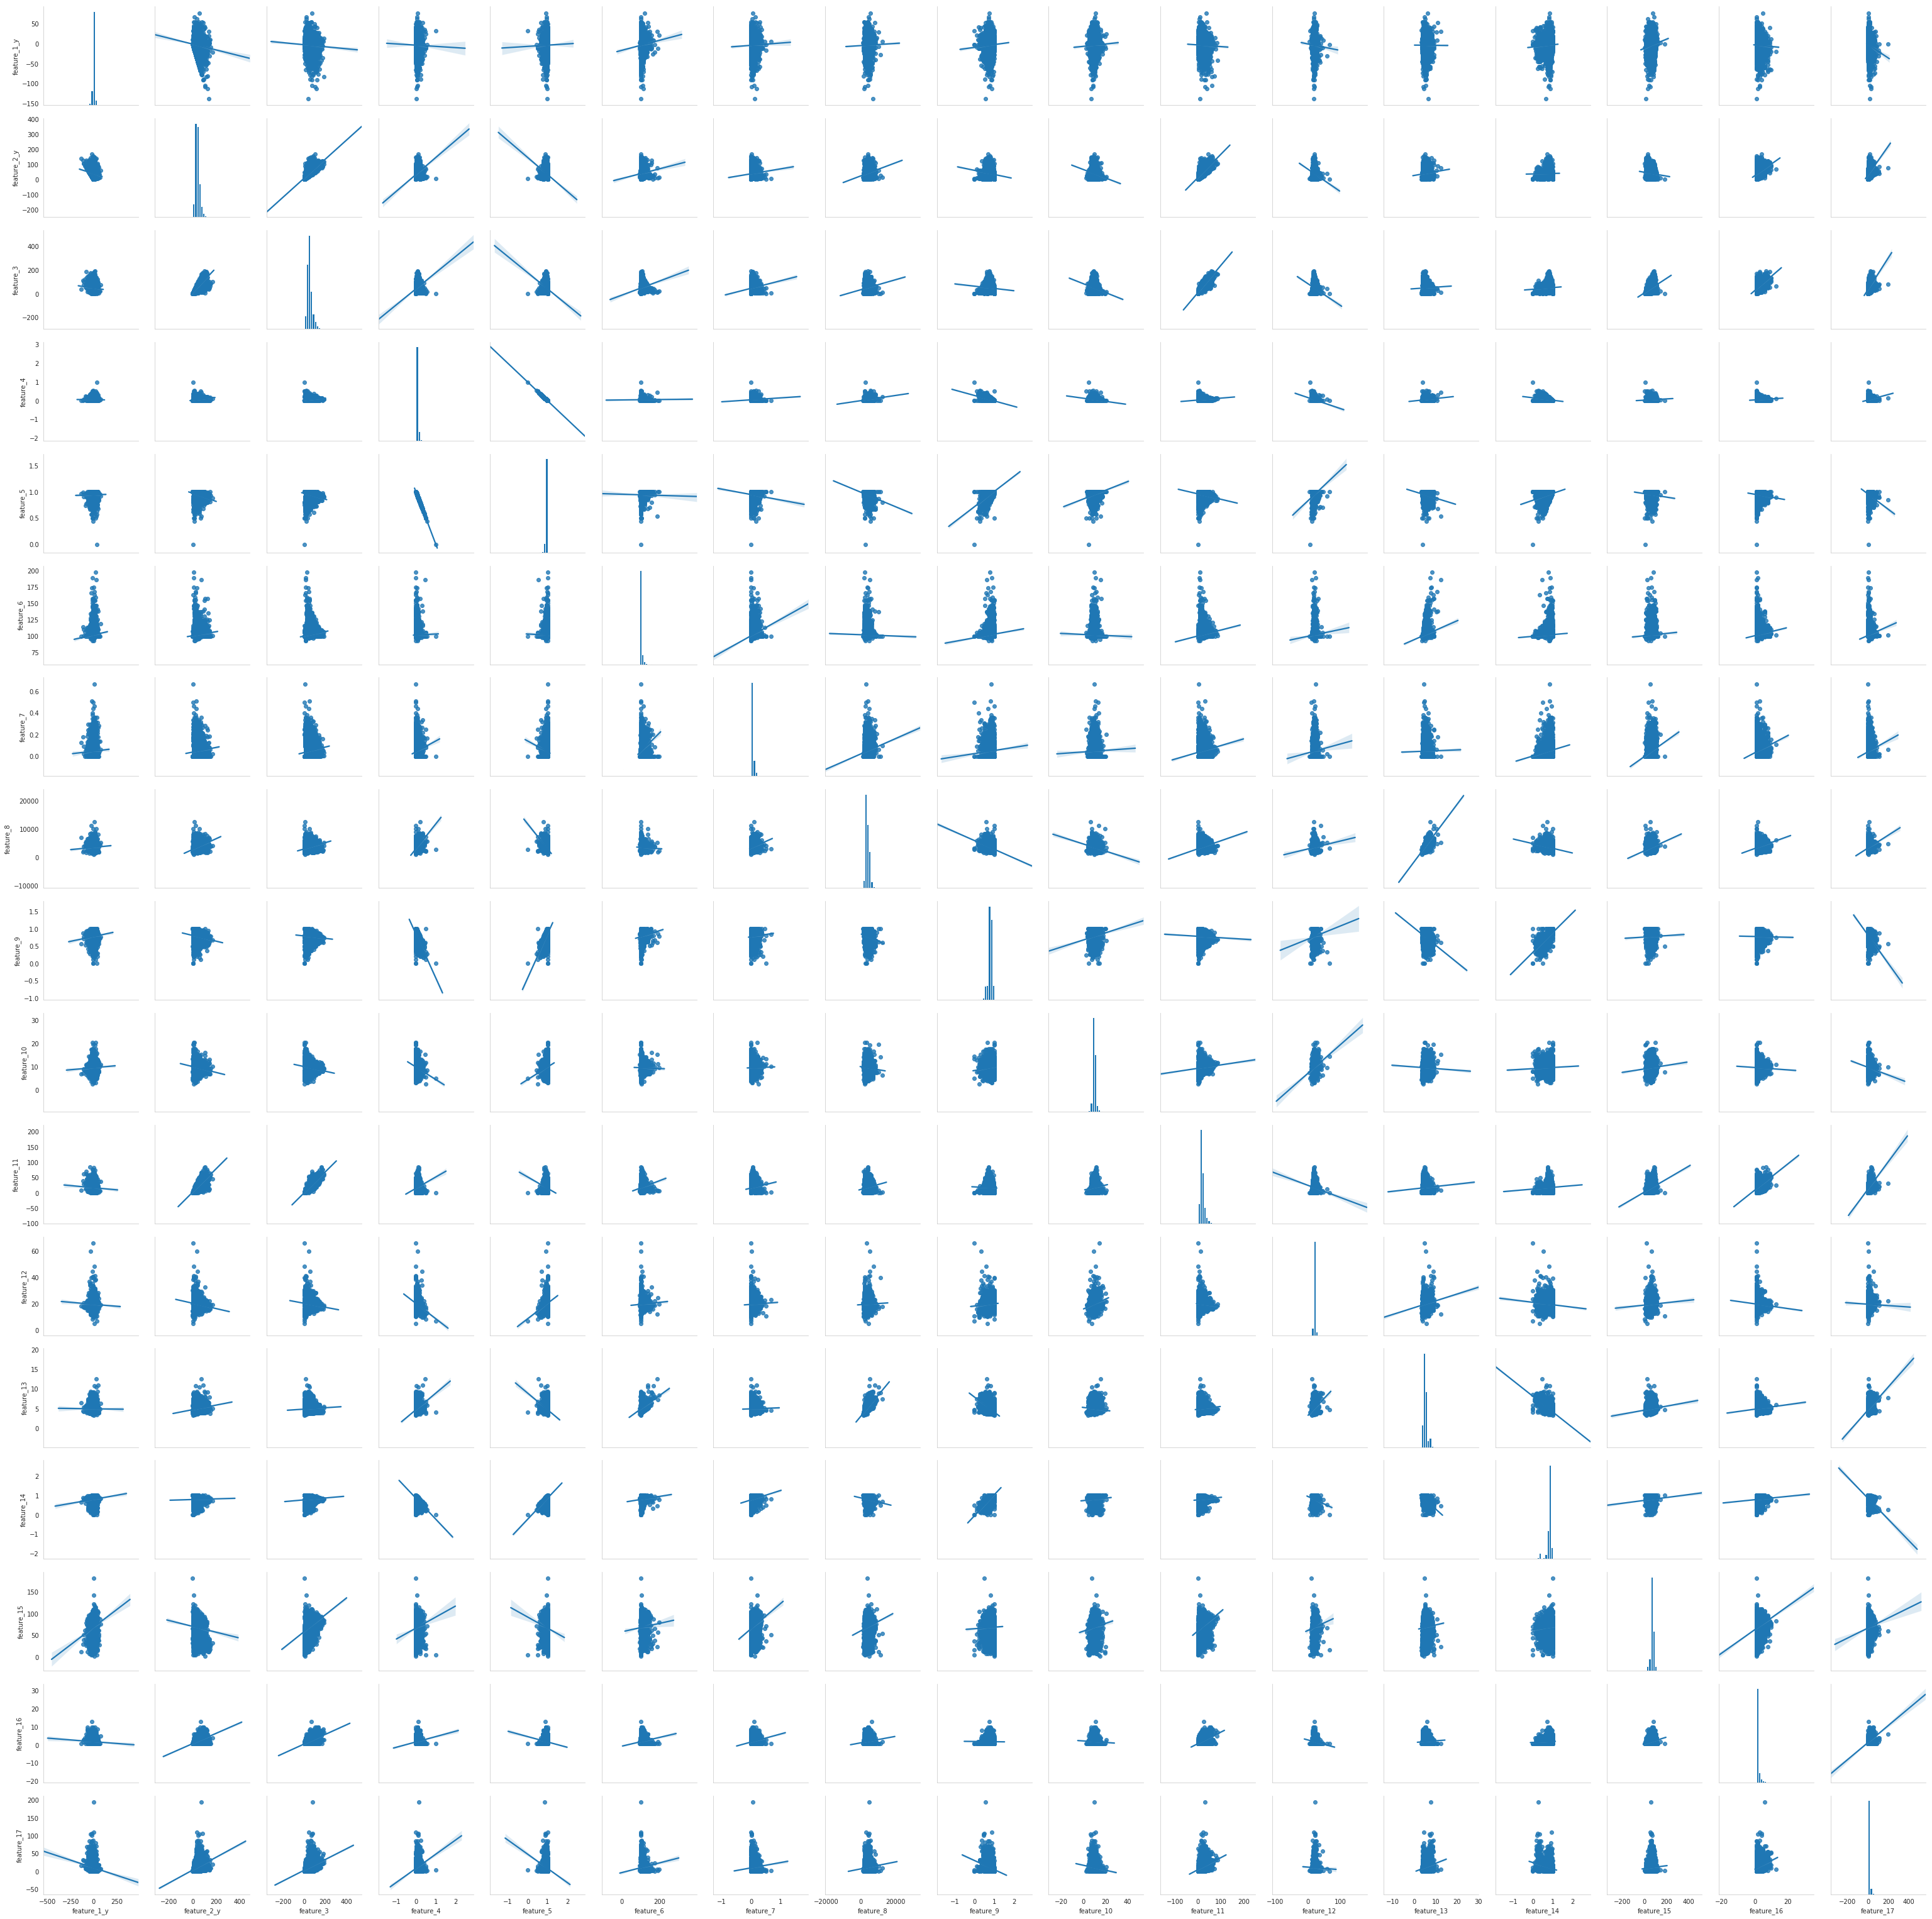

In [28]:
sb.pairplot(data[weekly_features], kind="reg")
plt.show()

In [29]:
data[weekly_features].corr()

,feature_1_y,feature_2_y,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
feature_1_y,1.000000,-0.120150,-0.053431,-0.013464,0.013468,0.063527,0.023888,0.029820,0.062260,0.031884,-0.033959,-0.031374,-0.004127,0.067479,0.136330,-0.039109,-0.120304
feature_2_y,-0.120150,1.000000,0.811612,0.296128,-0.296123,0.099688,0.084221,0.287669,-0.149793,-0.186398,0.770870,-0.173807,0.121208,0.023524,-0.092794,0.469315,0.416297
feature_3,-0.053431,0.811612,1.000000,0.276147,-0.276133,0.141943,0.126158,0.215254,-0.081457,-0.191008,0.884739,-0.165513,0.047374,0.082129,0.342983,0.561125,0.447954
feature_4,-0.013464,0.296128,0.276147,1.000000,-1.000000,0.012818,0.102225,0.348661,-0.606482,-0.210480,0.195520,-0.260943,0.230148,-0.375262,0.092274,0.127943,0.242393
feature_5,0.013468,-0.296123,-0.276133,-1.000000,1.000000,-0.012789,-0.102210,-0.348681,0.606492,0.210479,-0.195508,0.260948,-0.230161,0.375270,-0.092265,-0.127938,-0.242395
feature_6,0.063527,0.099688,0.141943,0.012818,-0.012789,1.000000,0.208619,-0.021821,0.098044,-0.016601,0.145202,0.039320,0.222261,0.064441,0.041278,0.122809,0.097122
feature_7,0.023888,0.084221,0.126158,0.102225,-0.102210,0.208619,1.000000,0.182274,0.061690,0.019007,0.121366,0.037636,0.014747,0.164343,0.206150,0.188400,0.088657
feature_8,0.029820,0.287669,0.215254,0.348661,-0.348681,-0.021821,0.182274,1.000000,-0.256481,-0.126647,0.212935,0.049262,0.735536,-0.188948,0.195957,0.194545,0.149727
feature_9,0.062260,-0.149793,-0.081457,-0.606482,0.606492,0.098044,0.061690,-0.256481,1.000000,0.124870,-0.037710,0.080839,-0.437017,0.784464,0.026961,-0.012423,-0.324642
feature_10,0.031884,-0.186398,-0.191008,-0.210480,0.210479,-0.016601,0.019007,-0.126647,0.124870,1.000000,0.110111,0.214664,-0.050243,0.055693,0.081380,-0.045886,-0.107011


* feature 2 and feature 3:  0.81
* feature 2 and feature 11: 0.77
* feature 3 and feature 11: 0.88
* feature 4 and feature 5:  -1
* feature 9 and feature 14: 0.78

Label data. If a specific courier’s week 9, 10 and 11 data is not provided, we label this
courier as “1” otherwise “0”. After labeling, remove week 8(Yes including 8!), 9, 10 and 11 data to
avoid bias in your next task

In [ ]:
data['label'] = ''*len(data)

last_weeks = [9,10,11]

grouped = data.groupby('courier')

couriers1 = list(set(grouped.filter(lambda x: x.week.max() < 9).courier))
couriers0 = list(set(grouped.filter(lambda x: x.week.max() >= 9).courier))


data.loc[data[data.courier.isin(couriers1)].index, 'label'] = 1
data.loc[data[data.courier.isin(couriers0)].index, 'label'] = 0

#there are a lot of couriers that don't have week data (bc they didn't have weekly data at all). Label those 1
data.loc[data[data.label==''].index, 'label'] = 1 


